In [1]:
import sqlite3
import numpy as np

def create_combined_database(combined_db_path):
    conn = sqlite3.connect(combined_db_path)
    c = conn.cursor()
    
    # Create a table for the combined arrays and their labels
    c.execute('''CREATE TABLE IF NOT EXISTS combined_arrays (
                  id INTEGER PRIMARY KEY,
                  combined_data BLOB,
                  label_data BLOB
                  )''')
    conn.commit()
    conn.close()


def combine_arrays_and_populate(source_db_path1, source_db_path2, combined_db_path, skip_step=10, combined_table_name='combined_arrays'):
    # Connect to the source databases and the combined database
    conn1 = sqlite3.connect(source_db_path1)
    conn2 = sqlite3.connect(source_db_path2)
    combined_conn = sqlite3.connect(combined_db_path)
    
    cursor1 = conn1.cursor()
    cursor2 = conn2.cursor()
    combined_cursor = combined_conn.cursor()
    
    # Fetch all arrays from the first source database
    cursor1.execute(f'SELECT id, data FROM slices_lc')
    arrays1 = cursor1.fetchall()
    
    # Fetch all arrays from the second source database
    cursor2.execute(f'SELECT id, data FROM slices_ns')
    arrays2 = cursor2.fetchall()
    
    append_counter = 0
    
    # Combine the arrays and populate the new database
    for id1, data1 in arrays1:
        array1 = np.frombuffer(data1, dtype=np.float32).reshape((64, 64))
        
        for id2, data2 in arrays2:
            if append_counter <= 2500000:  # Check if it's the 400th element
                array2 = np.frombuffer(data2, dtype=np.float32).reshape((64, 64)) * 0.1
                
                combined_array = array1 + array2
            
                # Normalize the combined array to 0 and 1
                min_val_combined = combined_array.min()
                max_val_combined = combined_array.max()
                normalized_combined_array = (combined_array - min_val_combined) / (max_val_combined - min_val_combined)

                normalized_array1 = (array1 - min_val_combined) / (max_val_combined - min_val_combined)

                threshold = (np.max(normalized_array1) + np.min(normalized_array1))/2 - 0.05*(np.max(normalized_array1))
                normalized_array1[normalized_array1 >= threshold] = 1.0
                normalized_array1[normalized_array1 < threshold] = 0.0
                
                # Serialize the normalized combined array and the normalized array1
                combined_data = normalized_combined_array.tobytes()
                label_data = normalized_array1.tobytes()
                
                # Insert into the combined database
                combined_cursor.execute(f'INSERT INTO {combined_table_name} (combined_data, label_data) VALUES (?, ?)', (combined_data, label_data))
            
            append_counter += 1  # Increment the counter after each combination
    
    # Commit changes and close connections
    combined_conn.commit()
    conn1.close()
    conn2.close()
    combined_conn.close()





In [2]:
# Paths to your databases
source_db_path1 = 'databases/lightcones_2D.db'
source_db_path2 = 'databases/noises_2D.db'
combined_db_path = 'databases/combined_2D_scaled_down_2500000_0.1_minmax.db'



create_combined_database(combined_db_path)
combine_arrays_and_populate(source_db_path1, source_db_path2, combined_db_path)




In [3]:
def count_combined_elements(db_path, table_name='combined_arrays'):
    # Connect to the combined database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Execute the count query
    cursor.execute(f'SELECT COUNT(*) FROM {table_name}')
    count = cursor.fetchone()[0]
    
    conn.close()
    
    print(f"Total number of combined elements in the database '{db_path}': {count}")

# Example usage
combined_db_path = 'databases/combined_2D_scaled_down_2500000_0.1_minmax.db'  # Use the path to your combined database
count_combined_elements(combined_db_path)

Total number of combined elements in the database 'databases/combined_2D_scaled_down_2500000_0.1_minmax.db': 2500001


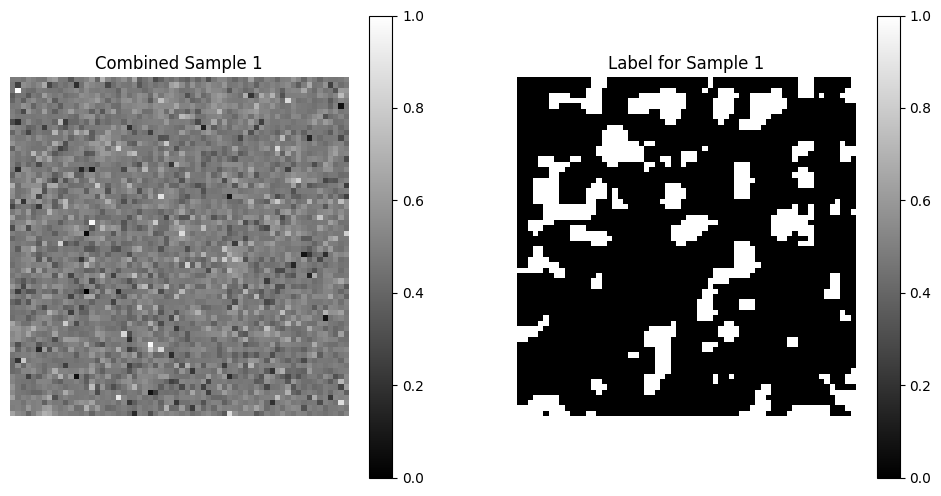

In [4]:
import matplotlib.pyplot as plt

def visualize_combined_sample(db_path, sample_id, table_name='combined_arrays'):
    # Connect to the database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Fetch a single combined sample by ID
    cursor.execute(f'SELECT combined_data, label_data FROM {table_name} WHERE id=?', (sample_id,))
    combined_data, label_data = cursor.fetchone()

    # Deserialize the data
    combined_array = np.frombuffer(combined_data, dtype=np.float32).reshape((64, 64))
    label_array = np.frombuffer(label_data, dtype=np.float32).reshape((64, 64))

    # Visualization
    plt.figure(figsize=(12, 6))

    # Plot the combined array
    plt.subplot(121)
    plt.imshow(combined_array, cmap='gray')
    plt.title(f"Combined Sample {sample_id}")
    plt.axis('off')
    plt.colorbar()

    # Plot the label array
    plt.subplot(122)
    plt.imshow(label_array, cmap='gray')
    plt.title(f"Label for Sample {sample_id}")
    plt.axis('off')
    plt.colorbar()

    plt.show()

    conn.close()

# Visualize a sample
visualize_combined_sample('databases/combined_2D_scaled_down_2500000_0.1_minmax.db', sample_id=1)

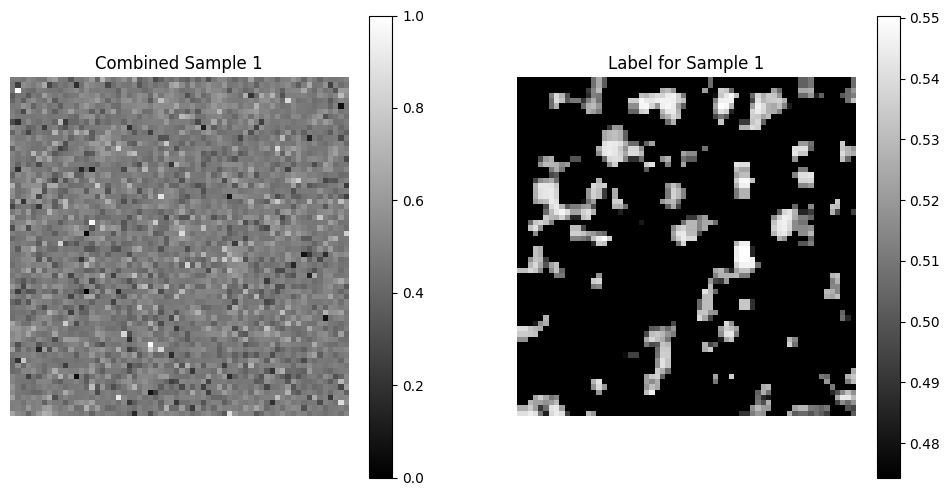